# 自製智能中文選字系統  (1)

In [5]:
import sys
sys.version

'3.7.11 (default, Jul  3 2021, 18:01:19) \n[GCC 7.5.0]'

## 資料前處理

確認版本為 python3

In [6]:
import re

In [7]:
def prepocess_line(line):
    # 僅僅挑出中文字元，並且斷開不連續的中文字
    # YOUR CODE HERE
    segments = re.findall("[\u4e00-\u9fff]+", line)
    # END YOUR CODE
    return segments

In [8]:
prepocess_line('“英語”一詞源於遷居英格蘭的日耳曼部落盎格魯（），而“盎格魯”得名於')  
# 應該為：['英語', '一詞源於遷居英格蘭的日耳曼部落盎格魯', '而', '盎格魯', '得名於']

['英語', '一詞源於遷居英格蘭的日耳曼部落盎格魯', '而', '盎格魯', '得名於']

In [9]:
segments = []
with open('./wiki_zh_small.txt') as fr:
    for line in fr.readlines():
        segments += prepocess_line(line)

## Ngram

一開始要先計算字詞出現的次數

In [10]:
from collections import Counter
class Counters:
    def __init__(self, n):
        self.n = n
        self.counters = [Counter() for _ in range(n + 1)]  # 分別代表計算0、1、...個字的出現次數

    def fit(self, segments):
        # 因為 self.counters 分別代表計算0、1、...個字的出現次數
        # 請在此實作利用 segments 以及函式 _skip 來統計次數
        # YOUR CODE HERE
        for i in range(1, self.n + 1):
          for indv in segments:
            self.counters[i].update(self._skip(indv, i))

        count = sum([len(segment) for segment in segments])
        self.counters[0] = Counter({'':count})
        # END YOUR CODE

    def __getitem__(self, k):
        return self.counters[k]

    def _skip(self, segment, n):
        assert n > 0
        if len(segment) < n:
            return []
        shift = n - 1
        for i in range(len(segment) - shift):
            yield segment[i:i+shift+1]

In [11]:
counters = Counters(n=3)
counters.fit(segments)

In [12]:
counters[0]
# 應該為： Counter({'': 371373})

Counter({'': 371373})

In [13]:
class Ngram:
    def __init__(self, n, counters):
        assert n <= counters.n
        self.n = n
        self.major_counter = counters[n]
        self.minor_counter = counters[n-1]

    def predict_proba(self, prefix='', top_k=5):
        assert len(prefix) >= self.n - 1
        # 使用 Ngram 的公式計算出下一個字出現的機率
        # 輸出為機率與字的tuple列表，詳見下方輸出範例
        # YOUR CODE HERE

        # use n+1 gram if there is a prefix of length n
        if self.n > 1:
          pre = prefix[0:]   # prefix[-(self.n-1)]
        #use unigram if there is no prefix
        else:
          pre = ''
        
        #previous word
        count_pre = self.minor_counter[pre]
        probs = []
        for k, c in dict(self.major_counter).items():
          if k.startswith(pre):
            prob = c / count_pre
            probs.append((prob, k[-1])) 

        sorted_probs = sorted(probs, reverse = True)

        # END YOUR CODE
        return sorted_probs[:top_k] if top_k > 0 else sorted_probs

    def get_proba_dict(self, prefix=''):
        return {word: prob for prob, word in self.predict_proba(prefix, top_k=-1)}


In [14]:
unigram = Ngram(1, counters)  # pre = prefix[0:]

In [15]:
unigram.predict_proba('我思')
# 應該為：[(0.035732269174118744, '的'),
#         (0.012927703414087723, '國'),
#         (0.010620050461395955, '中'),
#         (0.009984570768472667, '在'),
#         (0.009852627950874188, '一')]

[(0.035732269174118744, '的'),
 (0.012927703414087723, '國'),
 (0.010620050461395955, '中'),
 (0.009984570768472667, '在'),
 (0.009852627950874188, '一')]

In [16]:
bigram = Ngram(2, counters)
trigram = Ngram(3, counters)

In [17]:
ct = Counters(n = 5)
ct.fit(segments)
gram4 = Ngram(4, ct)
gram4.predict_proba("盎格魯")

[(0.3076923076923077, '族'),
 (0.07692307692307693, '親'),
 (0.07692307692307693, '街'),
 (0.07692307692307693, '撒')]

## 使用Ngram來建立第一版選字系統

In [21]:
class ChineseWordRecommenderV1:
    def __init__(self, unigram, bigram, trigram):
        self.unigram = unigram
        self.bigram = bigram
        self.trigram = trigram
    
    def predict_proba(self, prefix='', top_k=5):
        # 使用Ngram來建立選字系統
        # YOUR CODE HERE
        if len(prefix) == 0:
          return self.unigram.predict_proba(prefix, top_k)
        elif len(prefix) == 1:
          return self.bigram.predict_proba(prefix, top_k)
        elif len(prefix) > 1:
          return self.trigram.predict_proba(prefix, top_k)
        # END YOUR CODE

In [22]:
model = ChineseWordRecommenderV1(unigram, bigram, trigram)

In [23]:
probs = model.predict_proba('我思', top_k=10)
probs

[(0.75, '故'), (0.25, '維')]

## Demo

In [24]:
!pip install -U pip
!pip install -q ipywidgets

     |████████████████████████████████| 1.6 MB 8.7 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [26]:
import ipywidgets as widgets

text = widgets.Textarea()
label = widgets.Label()
display(label, text)

def func(change):
    probs = model.predict_proba(change.new, top_k=10)
    label.value = ' ' + '\t'.join([word for prob, word in probs])

text.observe(func, names='value')

Label(value='')

Textarea(value='')

# demo (in Google colab)

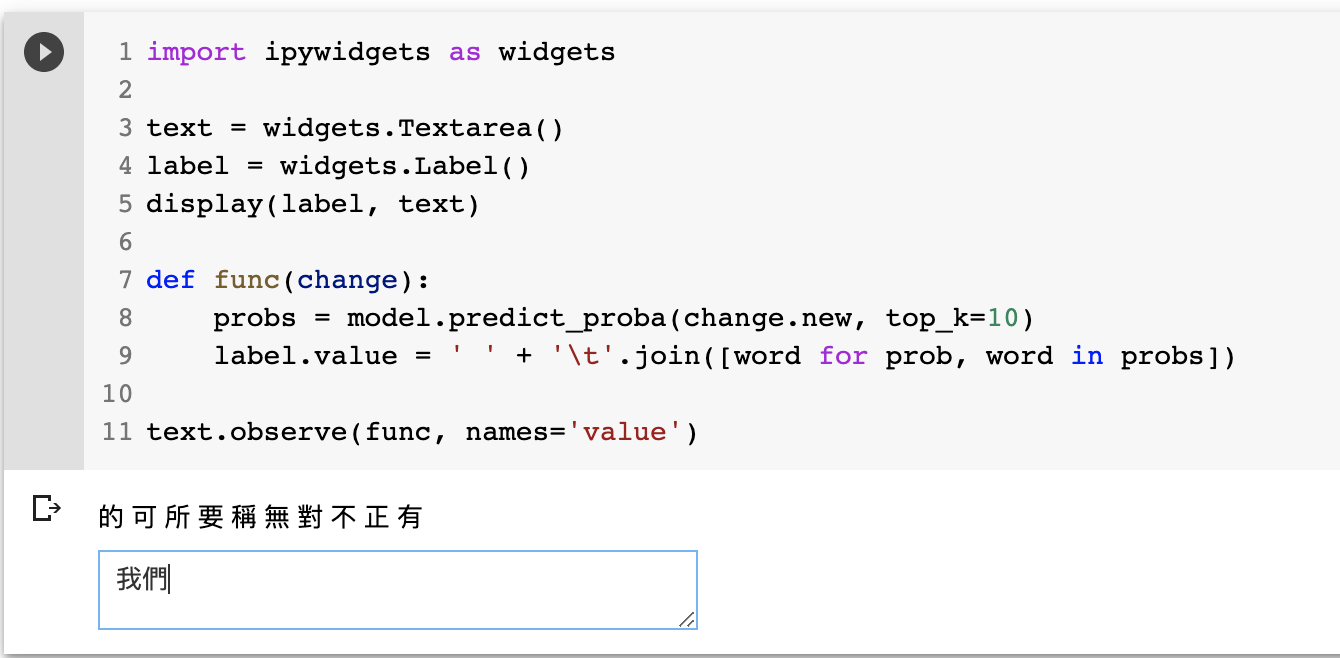